In [30]:
# We have a workflow that we will be using:
what_we_are_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [31]:
# Import the libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check your PyTorch version
torch.__version__

'2.2.1+cu121'

In [32]:
# We are going to learn to estimate a straight line
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now that we've gotten our data we will build a model.

this model will learn the relationship between X (features) and y (labels).

We will separate our data into training (80%) and test (20%) data.

In [33]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [34]:
# Let's create a function to visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    '''
    Plots training data, test data and compares predictions.
    '''
    plt.figure(figsize=(10, 7))

    # Plot the training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions data")

    # Show the legend
    plt.legend(prop={"size": 14})

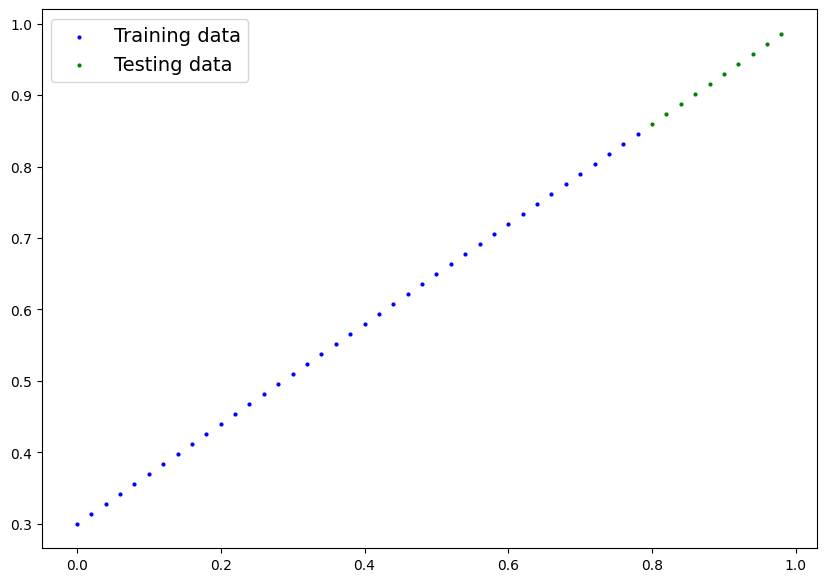

In [35]:
plot_predictions()

In [36]:
# We will make a linear regression model clss
class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [37]:
# Let's initialize a model and check the parameters
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [38]:
# We can get the state of the model using .state_dict()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [39]:
# Let's make some predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

In [40]:
# Let's check how well the predictions compare
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")
print(f"Actual values:\n{y_test}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
Actual values:
tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


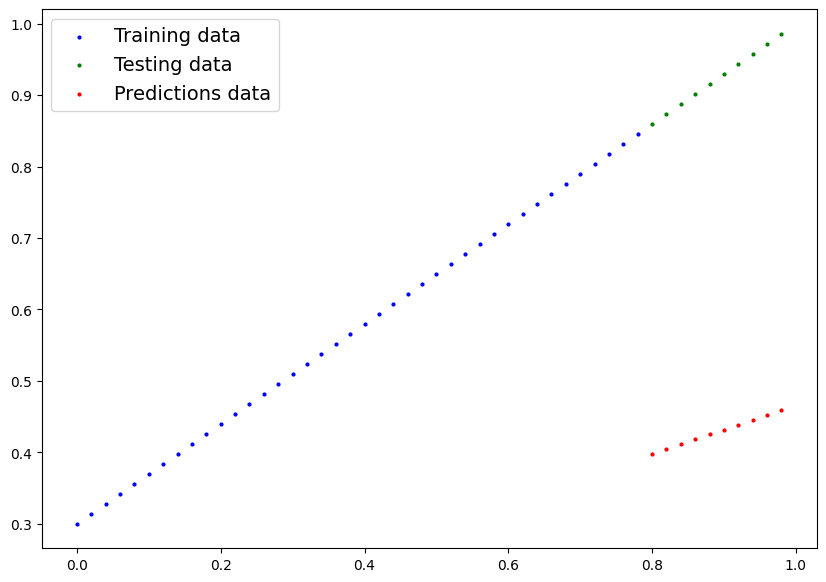

In [41]:
plot_predictions(predictions=y_preds)

In [42]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

In [47]:
# Let's train our model
# Create a loss function
loss_fn = nn.L1Loss() # Mean Absolute Error

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

In [48]:
# Let's make the training and testing loop:
torch.manual_seed(42)

# Set the number of epoch (how many times the model will pass through the loop)
EPOCHS = 500

# Create lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(EPOCHS):
    # Start with the training - put it in training mode
    model_0.train()

    # Forward pass on train data
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # Set the gradients of the optimizer to zero
    optimizer.zero_grad()

    # Calculate the loss backwards
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    # Now test the model - put it in testing mode
    model_0.eval()

    with torch.inference_mode():
        # Do a forward pass
        test_pred = model_0(X_test)

        # Calculate the loss on test data
        test_loss = loss_fn(test_pred, y_test)

        # Print every 10 epochs what is happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05683661624789238 
Epoch: 10 | MAE Train Loss: 0.02410869672894478 | MAE Test Loss: 0.056283850222826004 
Epoch: 20 | MAE Train Loss: 0.023764919489622116 | MAE Test Loss: 0.055525146424770355 
Epoch: 30 | MAE Train Loss: 0.02342205122113228 | MAE Test Loss: 0.054697759449481964 
Epoch: 40 | MAE Train Loss: 0.02307826466858387 | MAE Test Loss: 0.05387040972709656 
Epoch: 50 | MAE Train Loss: 0.022734660655260086 | MAE Test Loss: 0.05311169475317001 
Epoch: 60 | MAE Train Loss: 0.022391729056835175 | MAE Test Loss: 0.05228431895375252 
Epoch: 70 | MAE Train Loss: 0.022047825157642365 | MAE Test Loss: 0.051456958055496216 
Epoch: 80 | MAE Train Loss: 0.021704401820898056 | MAE Test Loss: 0.050698257982730865 
Epoch: 90 | MAE Train Loss: 0.02136128954589367 | MAE Test Loss: 0.04987088590860367 
Epoch: 100 | MAE Train Loss: 0.021017389371991158 | MAE Test Loss: 0.04904351755976677 
Epoch: 110 | MAE Train Loss: 0.02067414484

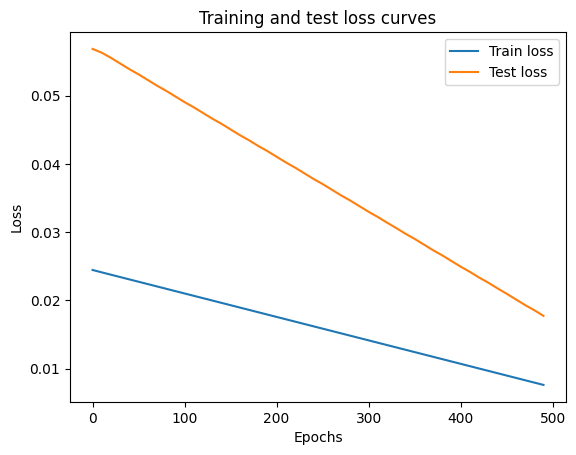

In [49]:
# Let's plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [50]:
# Let's look at our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3152]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [52]:
# Let's look a bit more at the testing setup
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8462],
        [0.8595],
        [0.8728],
        [0.8861],
        [0.8993],
        [0.9126],
        [0.9259],
        [0.9392],
        [0.9524],
        [0.9657]])

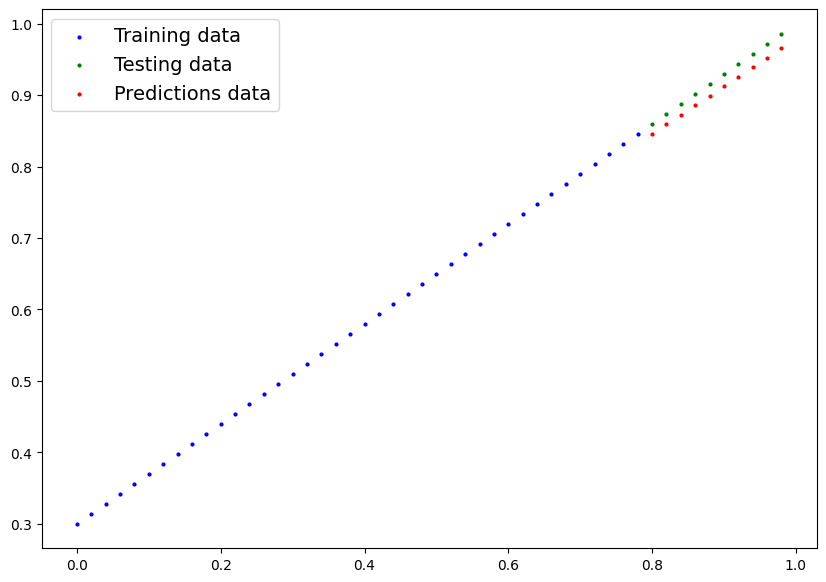

In [54]:
plot_predictions(predictions=y_preds)

In [55]:
# We might want to save our model
from pathlib import Path
# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create the model svae path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the models parameters
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)



Saving model to: models\01_pytorch_workflow_model_0.pth


In [58]:
# Let's load the model we saved
loaded_model_0 = LinearRegressionModel()

# Load the state 
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [59]:
# Let's test our model by predicting some values
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [60]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [62]:
# Let's go through it once more but with the device being agnostic
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.__version__ # if the version include +cu then you have GPU available

'2.2.1+cu121'

In [63]:
# Let's make the device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is: {device}")

Device is: cuda


In [64]:
# Let's create some starting values again (same as before)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [66]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

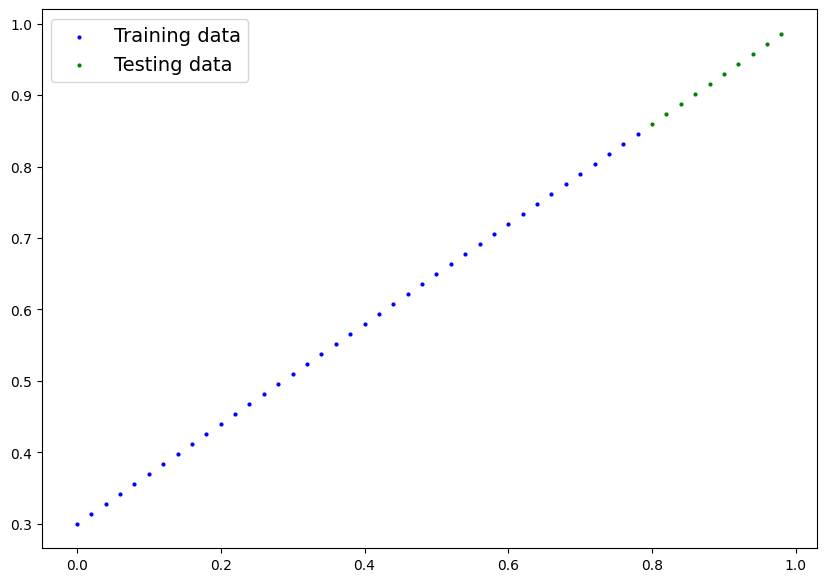

In [68]:
# Let's plot them
plot_predictions(X_train, y_train, X_test, y_test)

In [69]:
# We'll build the model again but now by using nn.Linear
class LinearRegressionModelV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [70]:
# Check which device the model is on
next(model_1.parameters()).device

device(type='cpu')

In [71]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [75]:
# Let's make the training and testing loop
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [76]:
torch.manual_seed(42)

EPOCHS = 1000

# Put the data on the available same agnostic device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(EPOCHS):

    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.006145037245005369 | Test loss: 0.01329870242625475
Epoch: 100 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 200 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 300 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 400 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 500 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 600 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 700 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 800 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743
Epoch: 900 | Train loss: 0.008066542446613312 | Test loss: 0.006364113185554743


In [77]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6981]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3088], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [78]:
# let's make some predictions
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8673],
        [0.8812],
        [0.8952],
        [0.9092],
        [0.9231],
        [0.9371],
        [0.9510],
        [0.9650],
        [0.9790],
        [0.9929]], device='cuda:0')

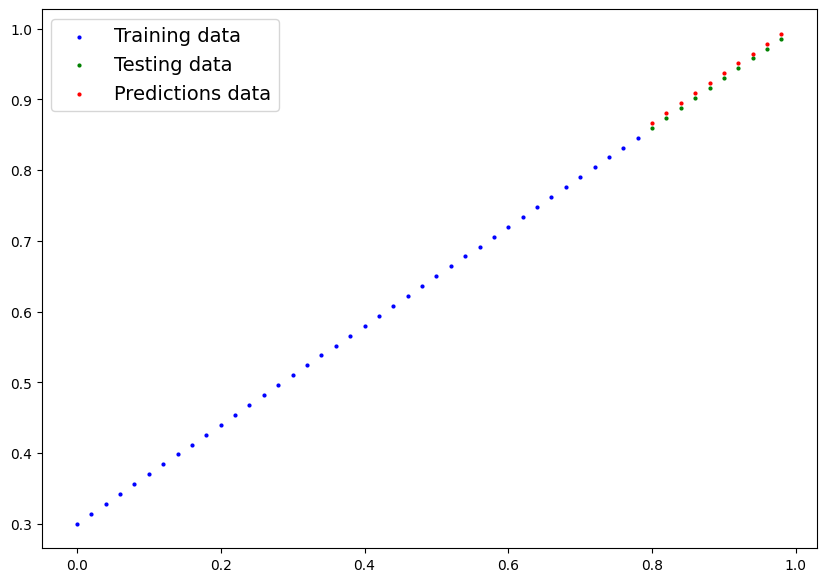

In [80]:
# Let's plot the results
plot_predictions(predictions=y_preds.cpu())

In [81]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_1.pth


In [82]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [83]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')